<a href="https://colab.research.google.com/github/hlx73/Image_ditiction_project/blob/main/ProjectML_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Import**

In [ ]:
!pip install gdown
# Data Processing
import pandas as pd
import numpy as np
import seaborn as sns
import random
!pip install rasterio scikit-learn
from rasterio.enums import Resampling
from PIL import Image
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
# [download the data]
file_id = "15Kz0yMK0ftt8p918pGYtKUP9O0nFGAph" # download the data

!gdown --id {file_id} -O data.zip


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=15Kz0yMK0ftt8p918pGYtKUP9O0nFGAph
From (redirected): https://drive.google.com/uc?id=15Kz0yMK0ftt8p918pGYtKUP9O0nFGAph&confirm=t&uuid=fa7d5a11-96e2-45a8-9922-90f3516f0f19
To: /content/data.zip
100% 8.38G/8.38G [01:41<00:00, 82.5MB/s]


In [ ]:
!file data.zip


data.zip: gzip compressed data, last modified: Mon Apr  6 23:22:09 2020, from Unix, original size modulo 2^32 37982208


In [ ]:
# --step1-- [Rename File]
!mv data.zip data.tar.gz

# --step2-- [Create Directory]
!mkdir data

# --step3-- [Extract Data]
!tar -xvzf data.tar.gz -C data


Streaming output truncated to the last 5000 lines.
train/targets/hurricane-florence_00000096_post_disaster_target.png
train/targets/socal-fire_00001135_post_disaster_target.png
train/targets/hurricane-michael_00000244_pre_disaster_target.png
train/targets/hurricane-harvey_00000436_post_disaster_target.png
train/targets/mexico-earthquake_00000055_post_disaster_target.png
train/targets/socal-fire_00001125_post_disaster_target.png
train/targets/socal-fire_00001049_pre_disaster_target.png
train/targets/hurricane-harvey_00000156_pre_disaster_target.png
train/targets/hurricane-michael_00000500_pre_disaster_target.png
train/targets/hurricane-harvey_00000329_post_disaster_target.png
train/targets/hurricane-harvey_00000406_pre_disaster_target.png
train/targets/hurricane-florence_00000304_post_disaster_target.png
train/targets/guatemala-volcano_00000026_post_disaster_target.png
train/targets/socal-fire_00000423_post_disaster_target.png
train/targets/socal-fire_00000878_pre_disaster_target.png
tr

In [ ]:
!ls data


train


In [ ]:
# --step4-- [List Train Directory]
!ls data/train

# --step5-- [List Target Files]
!ls data/train/targets | head


images	labels	targets
guatemala-volcano_00000000_post_disaster_target.png
guatemala-volcano_00000000_pre_disaster_target.png
guatemala-volcano_00000001_post_disaster_target.png
guatemala-volcano_00000001_pre_disaster_target.png
guatemala-volcano_00000002_post_disaster_target.png
guatemala-volcano_00000002_pre_disaster_target.png
guatemala-volcano_00000006_post_disaster_target.png
guatemala-volcano_00000006_pre_disaster_target.png
guatemala-volcano_00000007_post_disaster_target.png
guatemala-volcano_00000007_pre_disaster_target.png


In [ ]:
!ls data/train/images | head


guatemala-volcano_00000000_post_disaster.png
guatemala-volcano_00000000_pre_disaster.png
guatemala-volcano_00000001_post_disaster.png
guatemala-volcano_00000001_pre_disaster.png
guatemala-volcano_00000002_post_disaster.png
guatemala-volcano_00000002_pre_disaster.png
guatemala-volcano_00000006_post_disaster.png
guatemala-volcano_00000006_pre_disaster.png
guatemala-volcano_00000007_post_disaster.png
guatemala-volcano_00000007_pre_disaster.png


>**Data Exploration**

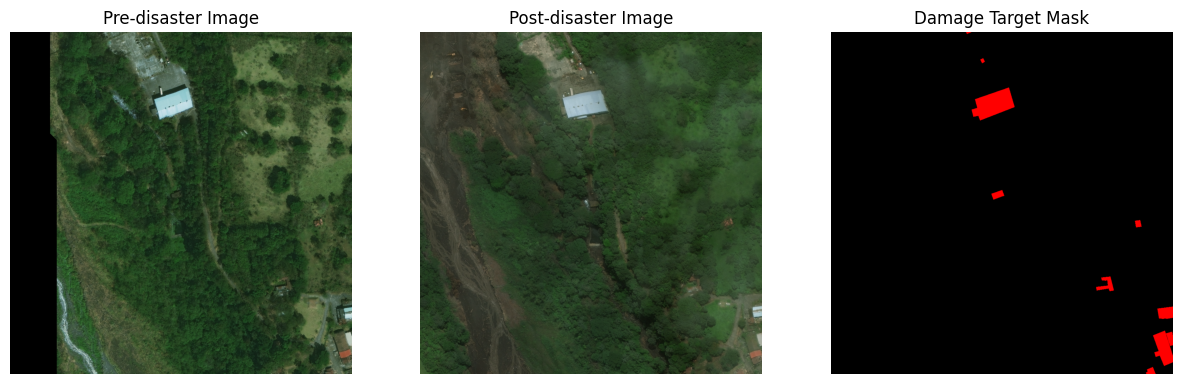

In [ ]:
# To avoid conflicts with IPython.display.Image, explicitly import PIL's Image with an alias.
from PIL import Image as PILImage

# --step1-- [Select Image ID]
img_id = "guatemala-volcano_00000000"

# --step2-- [Defining File Paths]
pre_path = f"data/train/images/{img_id}_pre_disaster.png"
post_path = f"data/train/images/{img_id}_post_disaster.png"
target_path = f"data/train/targets/{img_id}_post_disaster_target.png"

# --step3-- [Loading Images]
pre_img = PILImage.open(pre_path)
post_img = PILImage.open(post_path)
target_img = PILImage.open(target_path)

# --step4-- [Setting up the Plot]
plt.figure(figsize=(15,5))

# --step5-- [Pre-disaster]
plt.subplot(1,3,1)
plt.imshow(pre_img)
plt.title("Pre-disaster Image")
plt.axis("off")

# --step5-- [Post-disaster]
plt.subplot(1,3,2)
plt.imshow(post_img)
plt.title("Post-disaster Image")
plt.axis("off")

# --step5-- [Target Mask]
plt.subplot(1,3,3)
cmap_target = ListedColormap(['black', 'red']) # Black for 0 (no damage), Red for 1 (damage)
plt.imshow(target_img, cmap=cmap_target)
plt.title("Damage Target Mask")
plt.axis("off")

# --step6-- [Show the plot]
plt.show()

>**Preprocessing**

In [ ]:
# --step1-- [Uniform size between all images]
SIZE = (256, 256) # (Width , Height)

# --step2-- [We use BILINEAR it makes the colors graduated correctly when enlarged or reduced, and it is also suitable for natural images]
#           [We convert the image into a matrix of numbers to perform mathematical operations on it]
pre_arr = np.array(pre_img.resize(SIZE, PILImage.BILINEAR))       # Before the disaster
post_arr = np.array(post_img.resize(SIZE, PILImage.BILINEAR))     # After the disaster
mask_arr = np.array(target_img.resize(SIZE, PILImage.NEAREST))    # Take the nearest point

# --step3-- [Confirm dimensions]
print(pre_arr.shape, post_arr.shape, mask_arr.shape)
print("Mask values:", np.unique(mask_arr))

(256, 256, 3) (256, 256, 3) (256, 256)
Mask values: [0 1]


In [ ]:
# --step1-- [Get Image Dimensions]
H, W, C = pre_arr.shape              # Height, Width, Channels

# --step2-- [Combine pre- and post-disaster images into a single feature array]
X_img = np.concatenate([pre_arr, post_arr], axis=2)

# --step3-- [Convert image to table dynamically]
X = X_img.reshape(-1, X_img.shape[2])

# --step4-- [Flatten Target Mask]

y = mask_arr.reshape(-1)

# --step5-- [Check final shapes]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (65536, 6)
y shape: (65536,)


In [ ]:
# --step5-- [Check Class Imbalance]
unique_values, counts = np.unique(y, return_counts=True)

for val, cnt in zip(unique_values, counts):
    print(f"Class {val}: {cnt} pixels")


Class 0: 64547 pixels
Class 1: 989 pixels


>**ML Model Random Forest**

In [ ]:
# --step1-- [Splitting Data]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,        # 30% of data for testing
    random_state=42,
    stratify=y            # Keep the same ratio of 0s and 1s in train/test
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (45875, 6)
Test shape: (19661, 6)


In [ ]:
# --step2-- [Defining the Random Forest Model]
rf_clf = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest
    max_depth=None,       # Let trees grow fully no limit
    random_state=42,      # # Fix randomness
    n_jobs=-1,            # Use all processor cores to speed up training
    class_weight='balanced'
)

# --step3-- [Setup Hyperparameter Tuning]
# [Define options for the model to try and find the best ones]
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# --step4-- [Run Randomized Search]
# [Search for best parameters using Cross Validation]
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    n_iter=10,            # Try 10 random combinations
    cv=3,                 # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# --step5-- [Get Best Model & Evaluate]
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

# (Use the winner model to predict)
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}


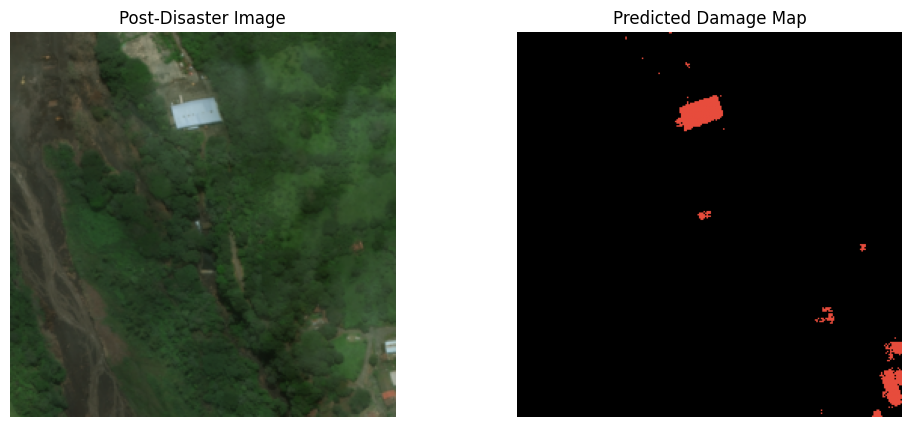

In [ ]:
# --step1-- [Load Specific Image]
# Force the specific ID for Guatemala Volcano to ensure consistent results
img_id = "guatemala-volcano_00000000"
pre_path = f"data/train/images/{img_id}_pre_disaster.png"
post_path = f"data/train/images/{img_id}_post_disaster.png"

# Load and resize the images manually here
SIZE = (256, 256)
pre_arr = np.array(PILImage.open(pre_path).resize(SIZE, PILImage.BILINEAR))
post_arr = np.array(PILImage.open(post_path).resize(SIZE, PILImage.BILINEAR))

# --step2-- [Prepare Data for Prediction]
X_full = np.concatenate([pre_arr, post_arr], axis=2)
X_full = X_full.reshape(-1, 6)

# --step3-- [Predict Full Map]
y_pred_full = best_rf_model.predict(X_full)

# --step4-- [Reshape to Map]
prediction_map = y_pred_full.reshape(256, 256)

# --step5-- [Visualization Settings] [Define colors: Black for Safe, Red for Damage]
import matplotlib.pyplot as plt
cmap = ListedColormap(['#000000', '#E74C3C'])
plt.figure(figsize=(12, 5))

# --step6-- [Plot Post-Disaster Image]
plt.subplot(1, 2, 1)
plt.imshow(post_arr)
plt.title("Post-Disaster Image")
plt.axis("off")

# --step7-- [Plot Predicted Damage Map]
plt.subplot(1, 2, 2)
plt.imshow(prediction_map, cmap=cmap)
plt.title("Predicted Damage Map")
plt.axis("off")

plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19364
           1       0.96      0.65      0.77       297

    accuracy                           0.99     19661
   macro avg       0.98      0.82      0.88     19661
weighted avg       0.99      0.99      0.99     19661

Confusion Matrix:
[[19356     8]
 [  105   192]]


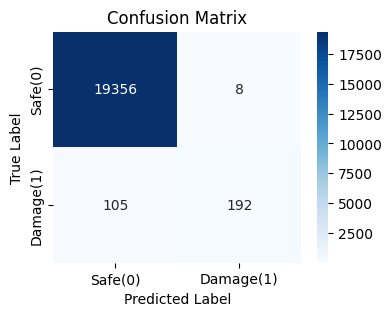

In [ ]:
# --step6-- [Training the Model]
rf_clf.fit(X_train, y_train)

# --step7-- [Prediction & Evaluation]
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# --step8-- [Confusion Matrix & Heatmap]
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Safe(0)', 'Damage(1)'],   # Predicted Labels
           yticklabels=['Safe(0)', 'Damage(1)'])   # Actual Labels

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

>**ROC AND AUC**

AUC Score: 0.9871


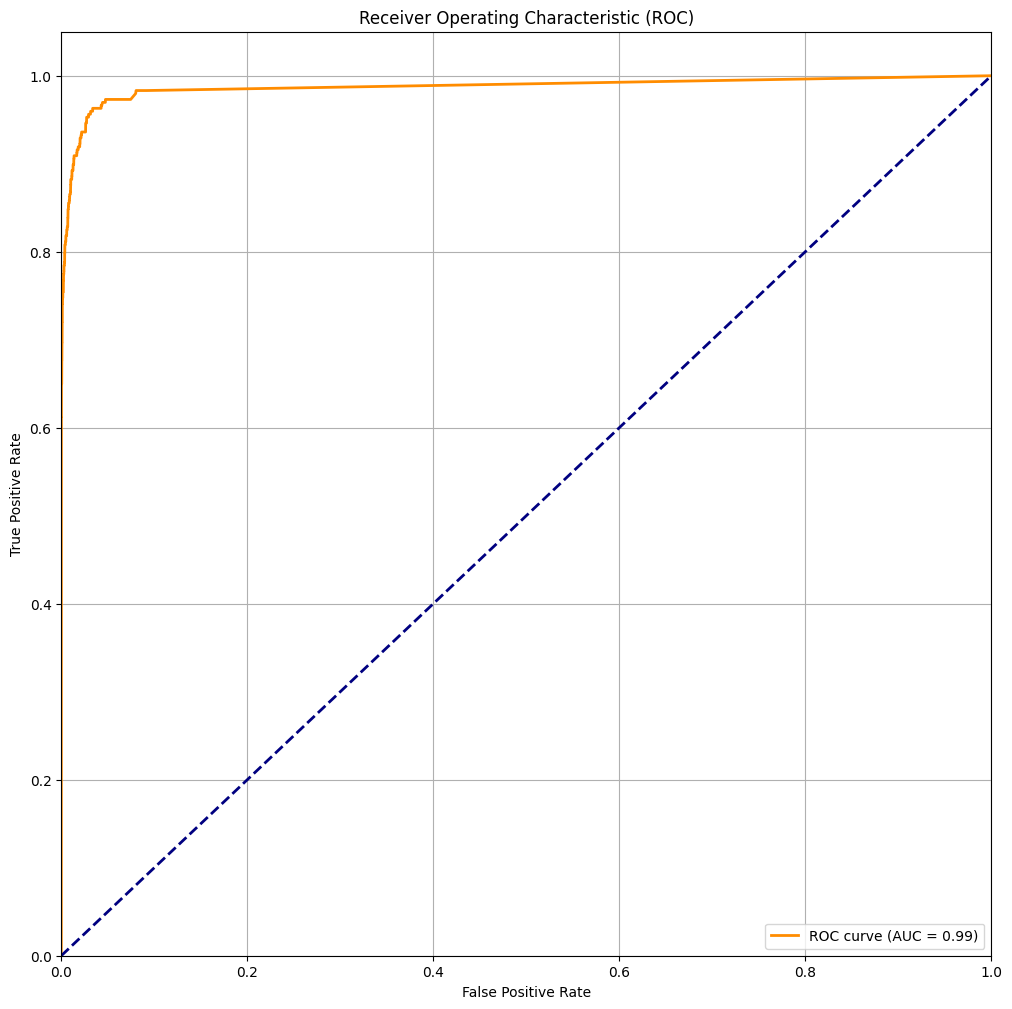

In [ ]:
from sklearn.metrics import roc_curve, auc

# --step1-- [Get Probabilities]
# (Get the probability score for Class 1 'Damage' instead of just 0/1)
y_prob = best_rf_model.predict_proba(X_test)[:, 1]

# --step2-- [Calculate ROC Points]
# (Calculate False Positive Rate & True Positive Rate to draw the curve)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# --step3-- [Plot ROC Curve]
plt.figure(figsize=(12, 12))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Line of random guessing

# --step4-- [Chart Labels]
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

>**Feature's importance of Random Forest Model**

/tmp/ipython-input-1265376369.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


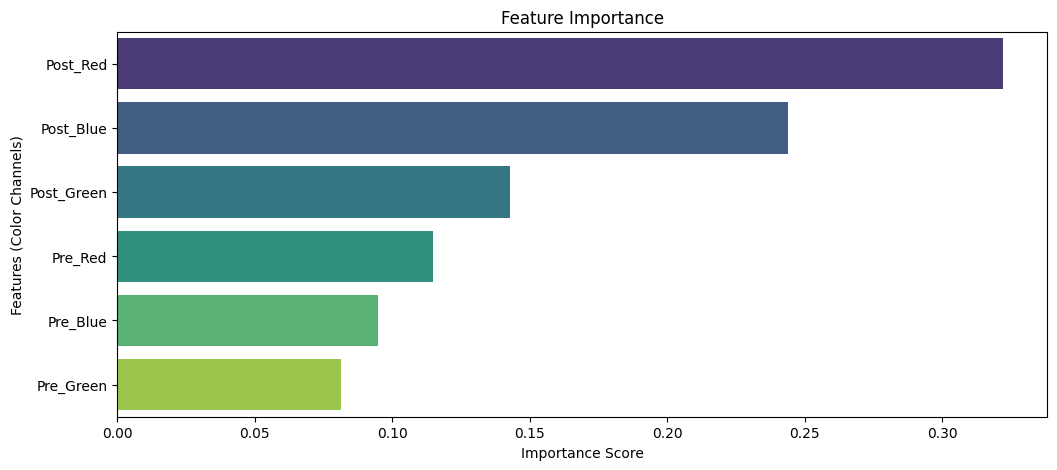

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --step1-- [Define Feature Names]
# (Since we have 6 channels: 3 for Pre-image and 3 for Post-image)
feature_names = ['Pre_Red', 'Pre_Green', 'Pre_Blue', 'Post_Red', 'Post_Green', 'Post_Blue']

# --step2-- [Get Importance Scores]
# [Extract numbers from the trained Random Forest model]
importances = rf_clf.feature_importances_

# --step3-- [Create DataFrame for Plotting]
# [Organize data into a table to make it easy to draw]
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Sort from highest to lowest

# --step4-- [Plot Feature Importance]
plt.figure(figsize=(12, 5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')

plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features (Color Channels)')
plt.show()

Selected Random IDs: ['santa-rosa-wildfire_00000268', 'socal-fire_00000501', 'hurricane-florence_00000151', 'socal-fire_00000332', 'socal-fire_00001318']


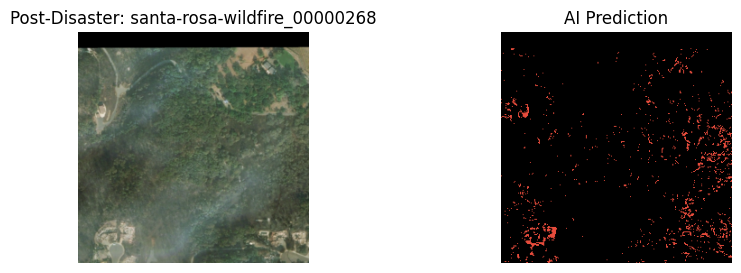

--------------------------------------------------


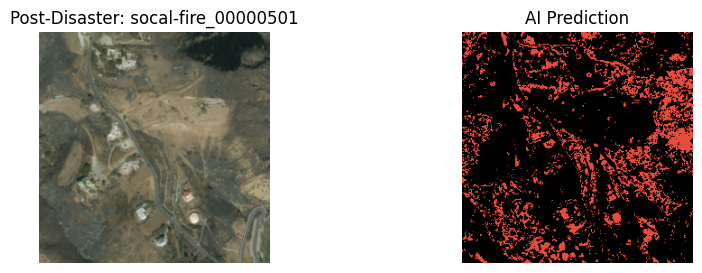

--------------------------------------------------


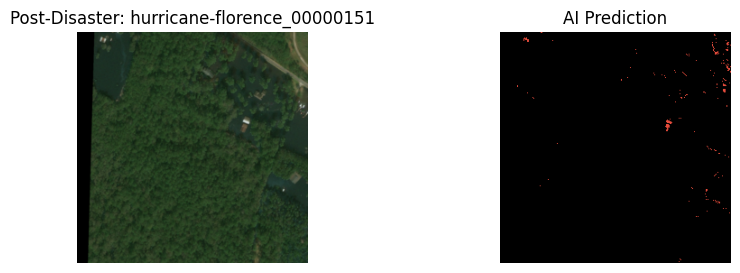

--------------------------------------------------


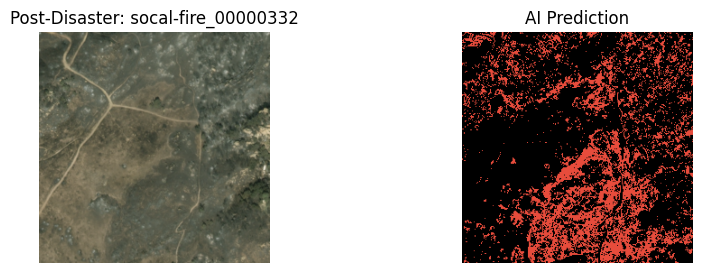

--------------------------------------------------


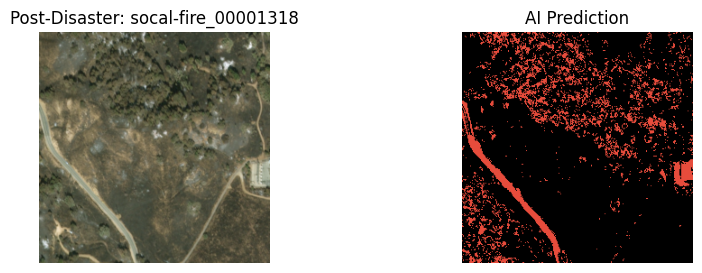

--------------------------------------------------


In [ ]:
# --step1-- [Get All Unique Image IDs]
# [Scan the folder to find all available image names]
image_folder = "data/train/images/"
all_files = os.listdir(image_folder)

# [Extract just the ID part from filenames like 'id_pre_disaster.png']
# We filter only 'pre' images to count each location once
all_ids = [f.replace('_pre_disaster.png', '') for f in all_files if '_pre_disaster.png' in f]

# --step2-- [Select 5 Random Images]
# [Pick 5 random IDs from the list every time we run this code]
random_samples = random.sample(all_ids, 5)

print(f"Selected Random IDs: {random_samples}")

# --step3-- [Loop Through Images]
for img_id in random_samples:
    # 1. Setup Paths
    pre_path = f"data/train/images/{img_id}_pre_disaster.png"
    post_path = f"data/train/images/{img_id}_post_disaster.png"

    # 2. Load and Preprocess
    pre_img = PILImage.open(pre_path)
    post_img = PILImage.open(post_path)

    SIZE = (256, 256)
    pre_arr = np.array(pre_img.resize(SIZE, PILImage.BILINEAR))
    post_arr = np.array(post_img.resize(SIZE, PILImage.BILINEAR))

    # Merge and Flatten
    X_new = np.concatenate([pre_arr, post_arr], axis=2).reshape(-1, 6)

    # 3. Predict [Using our best model]
    y_pred = best_rf_model.predict(X_new)

    # 4. Reshape to Map
    damage_map = y_pred.reshape(256, 256)

    # 5. Visualize
    plt.figure(figsize=(10, 3))

    # Show Original Post-Disaster
    plt.subplot(1, 2, 1)
    plt.imshow(post_arr)
    plt.title(f"Post-Disaster: {img_id}")
    plt.axis('off')

    # Show Prediction
    cmap = ListedColormap(['#000000', '#E74C3C']) # Green/Red
    plt.subplot(1, 2, 2)
    plt.imshow(damage_map, cmap=cmap)
    plt.title("AI Prediction")
    plt.axis('off')

    plt.show()
    print("-" * 50) # Separator line